In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import os
import sys
import h5py

from pymanticore.swift_analysis import HBTData, SOAPData
from pymanticore.cosmology import ra_dec_to_galactic
from pymanticore.analysis.matplotlib import get_mplstyle_path, ManticoreColors

In [3]:
# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

from stacking_backend import ClusterAnalysisPipeline, BasicPlotter, SummaryPlotter, MassScalingPlotter, MapConfig
from stacking_backend.data import PatchExtractor

# Config 
#config = MapConfig.for_planck_pr4(
#    y_map_path="Chandran_compy//PR4_NILC_y_map.fits",
#    masks_path="Chandran_compy//Masks.fits"
#)

config = MapConfig.for_planck_comcomp(
    y_map_path="COM_CompMap/COM_CompMap_YSZ_R2.02/milca_ymaps.fits",
    mask_path="COM_CompMap/COM_CompMap_YSZ_R2.02/COM_CompMap/COM_CompMap_YSZ_R2.02/"
)

# Initialize the analysis pipeline
#pipeline = ClusterAnalysisPipeline()

# Create plotters
#basic_plotter = BasicPlotter(pipeline.patch_extractor)
#summary_plotter = SummaryPlotter()
#mass_plotter = MassScalingPlotter()

#mnras_style = "mnras"

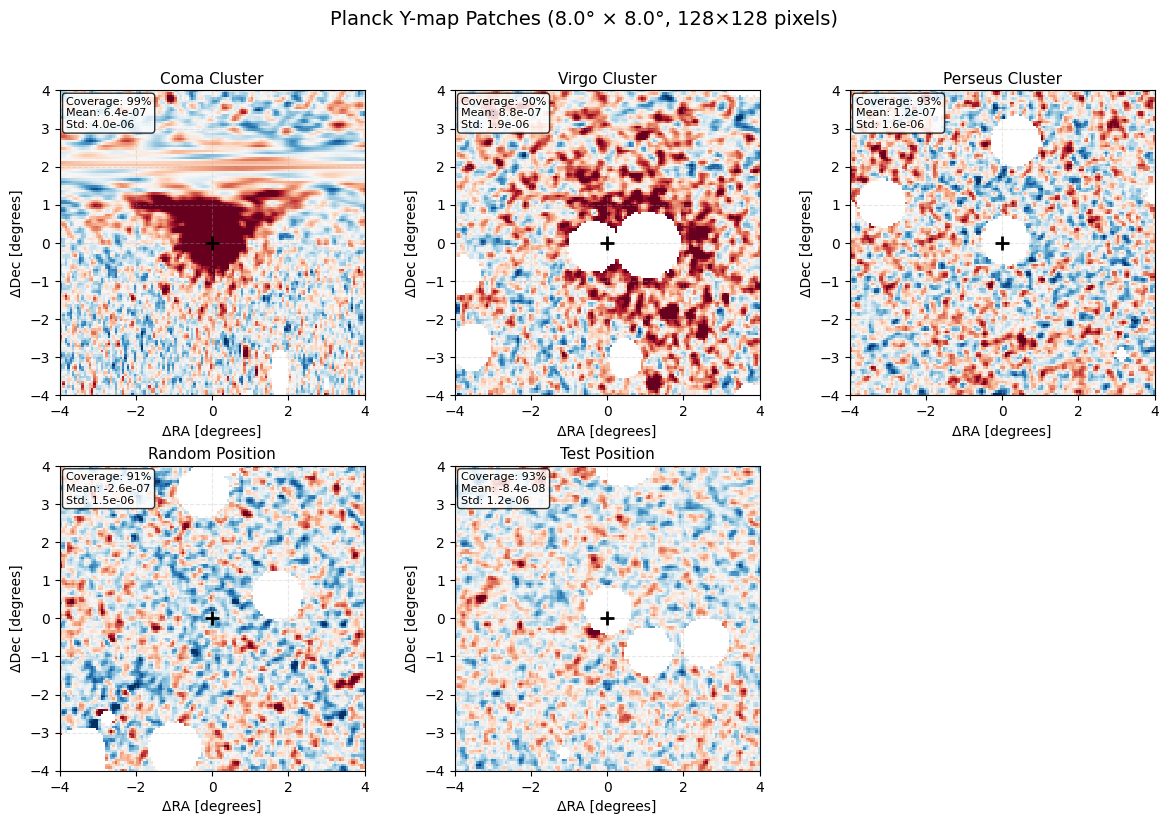


📊 Plotted 5 patches in 2×3 grid
  1. Coma Cluster: RA=194.95°, Dec=27.98°
  2. Virgo Cluster: RA=186.69°, Dec=12.83°
  3. Perseus Cluster: RA=23.40°, Dec=30.66°
  4. Random Position: RA=120.00°, Dec=0.00°
  5. Test Position: RA=168.10°, Dec=40.45°


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_example_patches(examples, basic_plotter, patch_size_deg=8.0, npix=128):
    """Plot Compton y-map patches for a list of example coordinates in a grid"""
    
    n_examples = len(examples)
    
    # Determine subplot grid dimensions
    if n_examples <= 3:
        nrows, ncols = 1, n_examples
    elif n_examples <= 6:
        nrows, ncols = 2, 3
    elif n_examples <= 9:
        nrows, ncols = 3, 3
    elif n_examples <= 12:
        nrows, ncols = 3, 4
    else:
        ncols = 4
        nrows = (n_examples + ncols - 1) // ncols
    
    # Create figure with subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    
    # Flatten axes array for easier indexing
    if nrows * ncols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Store all patches and determine global color scale
    all_patches = []
    all_vmin, all_vmax = float('inf'), float('-inf')
    
    # First pass: extract all patches and find global color limits
    for example in examples:
        # Convert RA/Dec to Galactic coordinates
        coord = SkyCoord(ra=example['ra']*u.deg, dec=example['dec']*u.deg, frame='icrs')
        gal_coord = coord.galactic
        gal_lon = gal_coord.l.deg
        gal_lat = gal_coord.b.deg
        
        # Extract patch
        patch_data, mask_patch = basic_plotter.patch_extractor.extract_patch(
            center_coords=(gal_lon, gal_lat),
            patch_size_deg=patch_size_deg,
            npix=npix
        )
        
        # Apply mask
        y_display = patch_data.copy()
        if mask_patch is not None:
            y_display[~mask_patch] = np.nan
        
        all_patches.append((y_display, mask_patch))
        
        # Update global color limits
        finite_data = y_display[np.isfinite(y_display)]
        if len(finite_data) > 0:
            vmin_patch, vmax_patch = np.percentile(finite_data, [5, 95])
            all_vmin = min(all_vmin, vmin_patch)
            all_vmax = max(all_vmax, vmax_patch)
    
    # Make color scale symmetric around zero
    vlim = max(abs(all_vmin), abs(all_vmax))
    vmin, vmax = -vlim, vlim
    
    # Second pass: plot all patches with consistent color scale
    for i, (example, (y_display, mask_patch)) in enumerate(zip(examples, all_patches)):
        ax = axes[i]
        
        # Plot extent
        extent = [-patch_size_deg/2, patch_size_deg/2, 
                  -patch_size_deg/2, patch_size_deg/2]
        
        # Plot y-map
        im = ax.imshow(y_display, extent=extent, origin='lower',
                      cmap='RdBu_r', vmin=vmin, vmax=vmax, interpolation='nearest')
        
        # Add center marker
        ax.plot(0, 0, 'k+', markersize=10, markeredgewidth=2)
        
        # Labels and formatting
        ax.set_xlabel('ΔRA [degrees]', fontsize=10)
        ax.set_ylabel('ΔDec [degrees]', fontsize=10)
        ax.set_title(example['title'], fontsize=11, pad=5)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_aspect('equal')
        
        # Add statistics text
        if mask_patch is not None:
            coverage = np.mean(mask_patch) * 100
        else:
            coverage = 100.0
        
        finite_data = y_display[np.isfinite(y_display)]
        if len(finite_data) > 0:
            mean_y = np.mean(finite_data)
            std_y = np.std(finite_data)
            stats_text = f'Coverage: {coverage:.0f}%\nMean: {mean_y:.1e}\nStd: {std_y:.1e}'
        else:
            stats_text = f'Coverage: {coverage:.0f}%\nNo valid data'
        
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', fontsize=8,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide any empty subplots
    for i in range(n_examples, len(axes)):
        axes[i].axis('off')
    
    # Overall title
    fig.suptitle(f'Planck Y-map Patches ({patch_size_deg}° × {patch_size_deg}°, {npix}×{npix} pixels)', 
                fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n📊 Plotted {n_examples} patches in {nrows}×{ncols} grid")
    for i, example in enumerate(examples):
        print(f"  {i+1}. {example['title']}: RA={example['ra']:.2f}°, Dec={example['dec']:.2f}°")

# Example usage
examples = [
    {'ra': 194.95, 'dec': 27.98, 'title': 'Coma Cluster'},
    {'ra': 186.69, 'dec': 12.83, 'title': 'Virgo Cluster'},
    {'ra': 23.40, 'dec': 30.66, 'title': 'Perseus Cluster'},
    {'ra': 120.0, 'dec': 0.0, 'title': 'Random Position'},
    {'ra': 168.1, 'dec': 40.45, 'title': 'Test Position'}
]

# Call the function
plot_example_patches(examples, basic_plotter, patch_size_deg=8.0, npix=128)

### Load MCXC cluster catalog


Plotting 2 most massive MCXC clusters:

📊 Example 1: MCXC Most Massive #1 (M500=1.45e+15 M☉)


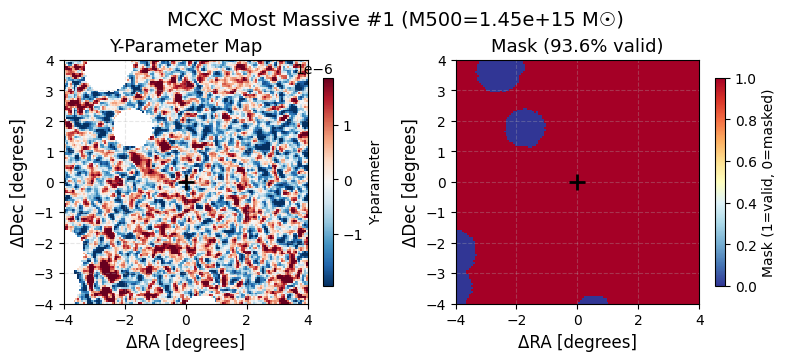

Patch shape: (128, 128)

📊 Example 2: MCXC Most Massive #2 (M500=1.44e+15 M☉)


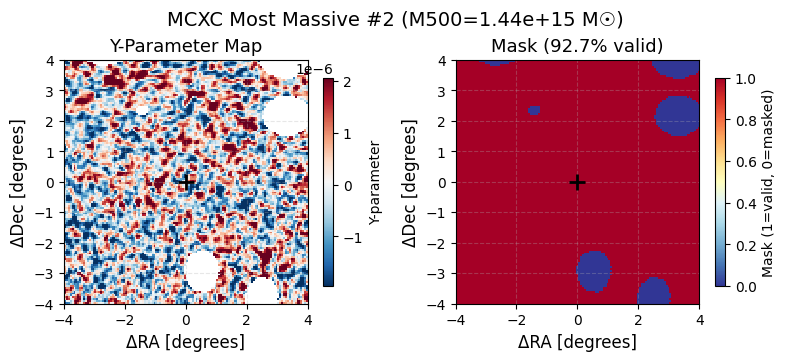

Patch shape: (128, 128)


In [5]:
# Load MCXC cluster catalog and plot 2 most massive
fname = "/cosma7/data/dp004/rttw52/Manticore/observational_data/mcxc_2_clusters/mcxc_clusters.hdf5"

with h5py.File(fname, "r") as f:
    _mcxc_data = f["all_clusters"][...]

_ra = np.degrees(_mcxc_data["phi"])
_dec = np.degrees(_mcxc_data["theta"])
gal_l, gal_b = ra_dec_to_galactic(_ra, _dec)
mcxc_data = {"gal_l": gal_l, "gal_b": gal_b, "z": _mcxc_data["z"], "m500": _mcxc_data["M500"]*1e14, "r500": _mcxc_data["R500"]}

# Find 2 most massive clusters and plot them
mass_indices = np.argsort(mcxc_data["m500"])[-2:][::-1]  # Get indices of 2 most massive, descending order

mcxc_massive_examples = []
for i, idx in enumerate(mass_indices):
    mcxc_massive_examples.append({
        'ra': _ra[idx],
        'dec': _dec[idx], 
        'title': f'MCXC Most Massive #{i+1} (M500={mcxc_data["m500"][idx]:.2e} M☉)'
    })

print(f"\nPlotting 2 most massive MCXC clusters:")
plot_example_patches(mcxc_massive_examples, basic_plotter)

### Load eROSITA cluster catalog


Plotting 2 most massive eROSITA clusters:

📊 Example 1: eROSITA Most Massive #1 (M500=1.00e+16 M☉)


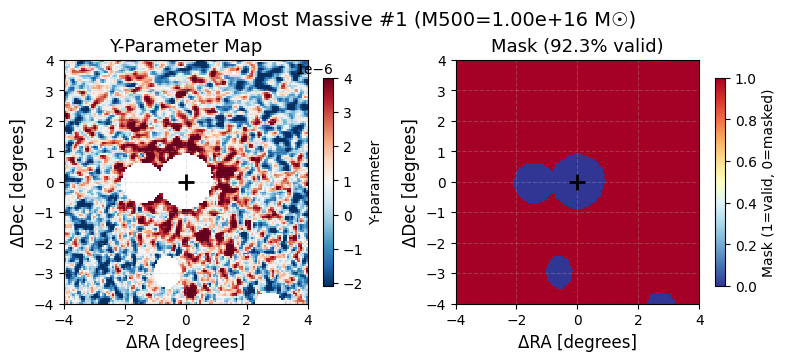

Patch shape: (128, 128)

📊 Example 2: eROSITA Most Massive #2 (M500=1.58e+15 M☉)


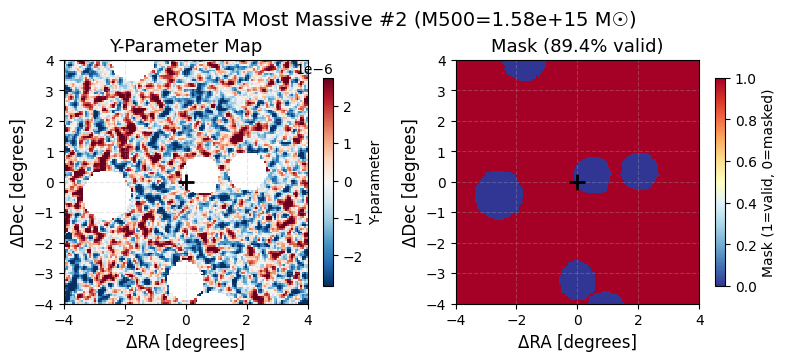

Patch shape: (128, 128)


In [7]:
# Load eROSITA cluster catalog and plot 2 most massive
fname = "/cosma7/data/dp004/rttw52/Manticore/observational_data/erosita_clusters/erosita_clusters.hdf5"

with h5py.File(fname, "r") as f:
    _eros_data = f["all_clusters_high_quality"][...]

_ra = np.degrees(_eros_data["phi"])
_dec = np.degrees(_eros_data["theta"])
gal_l, gal_b = ra_dec_to_galactic(_ra,_dec)
eros_data = {"gal_l": gal_l, "gal_b": gal_b, "z": _eros_data["z"], "m500": _eros_data["M500"]*1e14, "r500": _eros_data["R500"]}

# Find 2 most massive clusters and plot them
mass_indices = np.argsort(eros_data["m500"])[-2:][::-1]  # Get indices of 2 most massive, descending order

eros_massive_examples = []
for i, idx in enumerate(mass_indices):
    eros_massive_examples.append({
        'ra': _ra[idx],
        'dec': _dec[idx],
        'title': f'eROSITA Most Massive #{i+1} (M500={eros_data["m500"][idx]:.2e} M☉)'
    })

print(f"\nPlotting 2 most massive eROSITA clusters:")
plot_example_patches(eros_massive_examples, basic_plotter)

## Load Manticore posterior clusters


Plotting 2 most massive Manticore clusters:

📊 Example 1: Manticore Most Massive #1 (M500=3.62e+14 M☉)


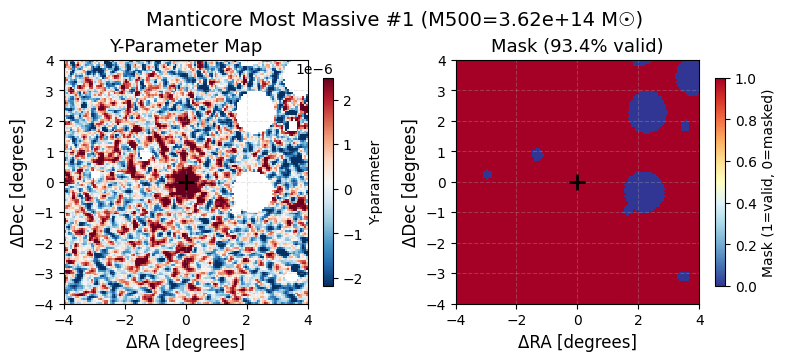

Patch shape: (128, 128)

📊 Example 2: Manticore Most Massive #2 (M500=3.49e+14 M☉)


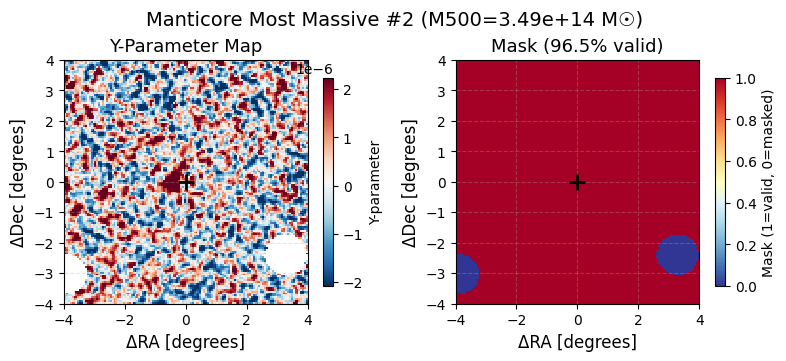

Patch shape: (128, 128)

📊 Example 3: Manticore Most Massive #3 (M500=3.28e+14 M☉)


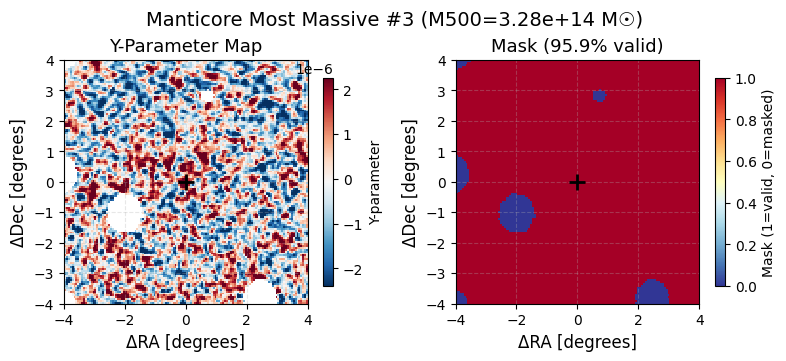

Patch shape: (128, 128)

📊 Example 4: Manticore Most Massive #4 (M500=3.28e+14 M☉)


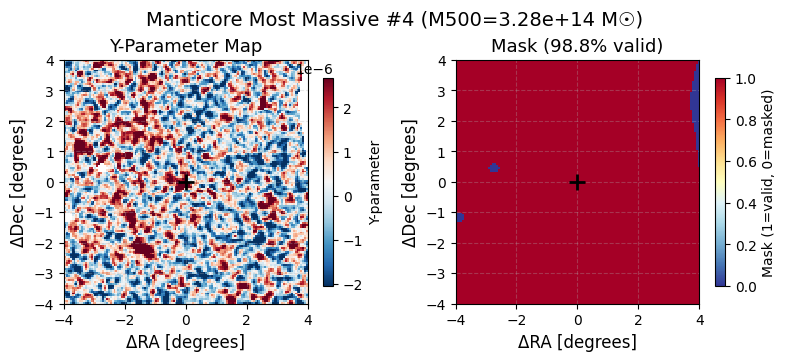

Patch shape: (128, 128)

📊 Example 5: Manticore Most Massive #5 (M500=3.21e+14 M☉)


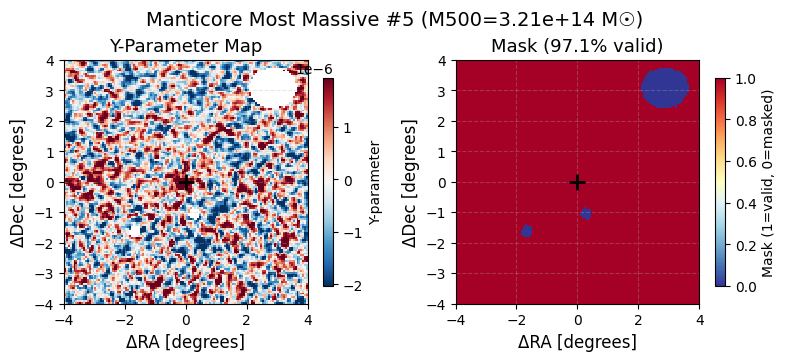

Patch shape: (128, 128)

📊 Example 6: Manticore Most Massive #6 (M500=3.16e+14 M☉)


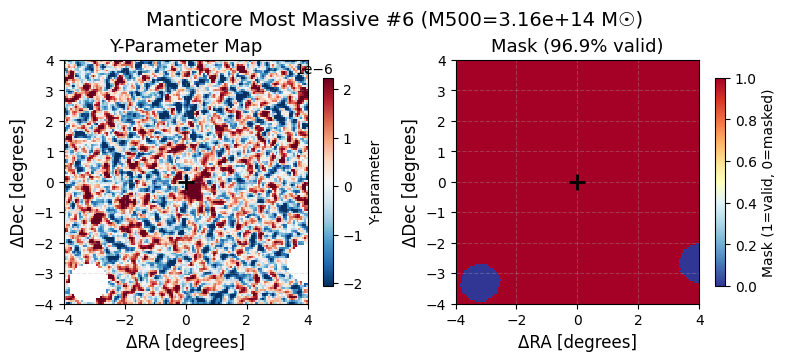

Patch shape: (128, 128)

📊 Example 7: Manticore Most Massive #7 (M500=3.03e+14 M☉)


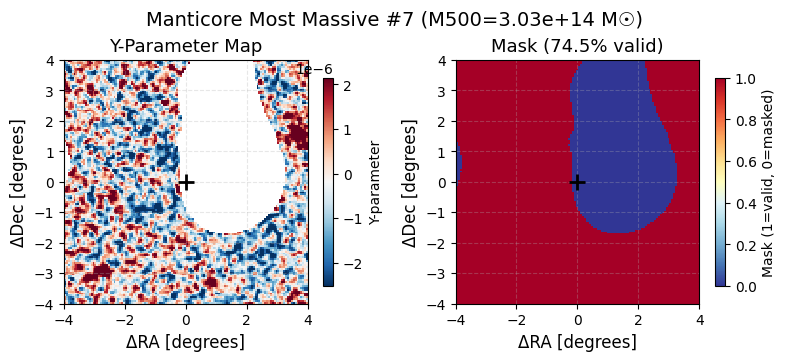

Patch shape: (128, 128)

📊 Example 8: Manticore Most Massive #8 (M500=2.88e+14 M☉)


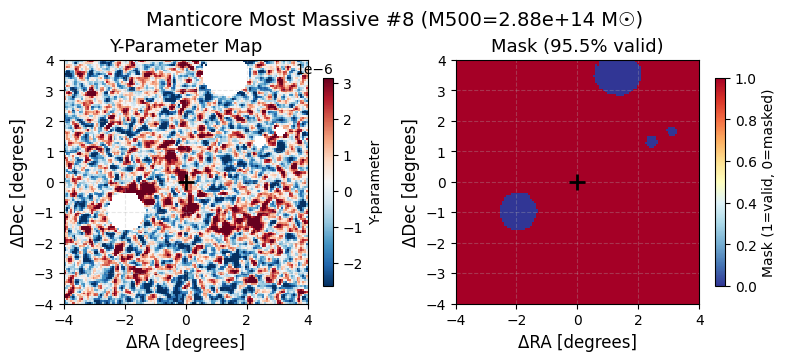

Patch shape: (128, 128)

📊 Example 9: Manticore Most Massive #9 (M500=2.79e+14 M☉)


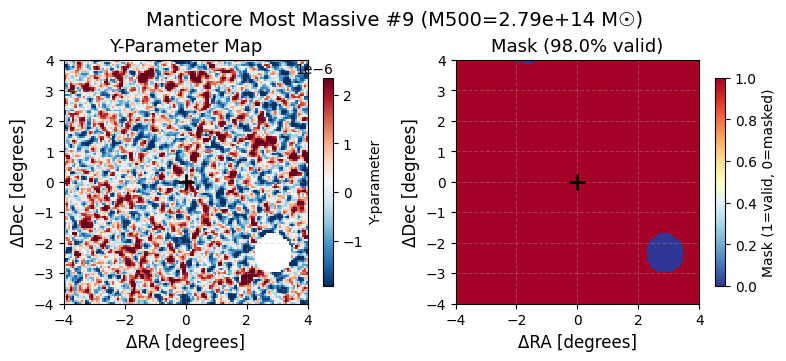

Patch shape: (128, 128)

📊 Example 10: Manticore Most Massive #10 (M500=2.62e+14 M☉)


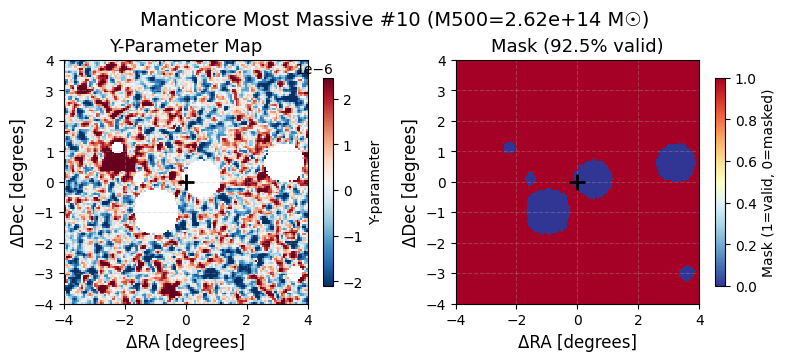

Patch shape: (128, 128)


In [8]:
# Load Manticore posterior clusters and plot 2 most massive
import numpy as np
import h5py
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u

fname = "/cosma7/data/dp004/rttw52/Manticore/new_analysis/clusters/posterior_associations/output/simplified_clusters.h5"

with h5py.File(fname, "r") as f:
    distances_mpc = f["clusters/median_properties/dist"][...]
    
    # Convert comoving distance to redshift using Planck18 cosmology
    redshifts = []
    for dist in distances_mpc:
        z = z_at_value(Planck18.comoving_distance, dist * u.Mpc)
        redshifts.append(z)
    
    manticore_data = {"gal_l": f["clusters/median_properties/gal_l"][...],
                      "gal_b": f["clusters/median_properties/gal_b"][...],
                      "m500": f["clusters/median_properties/SO_500_crit_TotalMass"][...],
                      "r500": f["clusters/median_properties/SO_500_crit_SORadius"][...],
                      "dist": distances_mpc,
                      "z": np.array(redshifts),
                      "ra": f["clusters/median_properties/ra"][...],
                      "dec": f["clusters/median_properties/dec"][...]}

# Find 2 most massive clusters and plot them
mass_indices = np.argsort(manticore_data["m500"])[-30:-20][::-1]  # Get indices of 2 most massive, descending order

manticore_massive_examples = []
for i, idx in enumerate(mass_indices):
    # Convert galactic to RA/Dec
    coord = SkyCoord(l=manticore_data["gal_l"][idx]*u.deg, b=manticore_data["gal_b"][idx]*u.deg, frame='galactic')
    icrs_coord = coord.icrs
    
    manticore_massive_examples.append({
        'ra': manticore_data["ra"][idx],
        'dec': manticore_data["dec"][idx],
        'title': f'Manticore Most Massive #{i+1} (M500={manticore_data["m500"][idx]:.2e} M☉)'
    })

print(f"\nPlotting 2 most massive Manticore clusters:")
plot_example_patches(manticore_massive_examples, basic_plotter)

In [9]:
def plot_halo_overview(halo_data, z_min=None, z_max=None, figsize=(15, 10), cat_name=""):
    """
    Plot overview of cluster data.
    
    Parameters
    ----------
    halo_data : dict
        Dictionary containing cluster data with keys: 'gal_l', 'gal_b', 'z', 'm500', 'r500'
    z_min : float, optional
        Minimum redshift to include in plots
    z_max : float, optional
        Maximum redshift to include in plots
    figsize : tuple, optional
        Figure size (width, height)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Apply redshift filter if specified
    if z_min is not None or z_max is not None:
        z_mask = np.ones(len(halo_data["z"]), dtype=bool)
        if z_min is not None:
            z_mask &= (halo_data["z"] >= z_min)
        if z_max is not None:
            z_mask &= (halo_data["z"] <= z_max)

        # Create filtered data
        filtered_data = {key: np.array(values)[z_mask] for key, values in halo_data.items()}
        title_suffix = f" (z: {z_min or 'min'} - {z_max or 'max'})"
    else:
        filtered_data = halo_data
        title_suffix = ""
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'{cat_name} Clusters Overview{title_suffix}', fontsize=16, fontweight='bold')

    # 1. Sky distribution in galactic coordinates
    ax1 = axes[0, 0]
    scatter = ax1.scatter(filtered_data["gal_l"], filtered_data["gal_b"], 
                         c=filtered_data["z"], cmap='viridis', alpha=0.7, s=20)
    ax1.set_xlabel('Galactic Longitude (deg)')
    ax1.set_ylabel('Galactic Latitude (deg)')
    ax1.set_title('Sky Distribution (colored by redshift)')
    ax1.set_xlim(0, 360)
    ax1.set_ylim(-90, 90)
    plt.colorbar(scatter, ax=ax1, label='Redshift')

    # 2. Redshift distribution
    ax2 = axes[0, 1]
    ax2.hist(filtered_data["z"], bins=30, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Redshift')
    ax2.set_ylabel('Number of Clusters')
    ax2.set_title('Redshift Distribution')
    
    # Mean and median lines
    ax2.axvline(np.mean(filtered_data["z"]), color='orange', linestyle='-', 
               label=f'Mean: {np.mean(filtered_data["z"]):.3f}')
    ax2.axvline(np.median(filtered_data["z"]), color='red', linestyle='--', 
               label=f'Median: {np.median(filtered_data["z"]):.3f}')
    
    # Add mean and median redshift lines for z <= 0.06
    low_z_mask = np.array(filtered_data["z"]) <= 0.06
    if np.any(low_z_mask):
        low_z_mean = np.mean(np.array(filtered_data["z"])[low_z_mask])
        low_z_median = np.median(np.array(filtered_data["z"])[low_z_mask])
        ax2.axvline(low_z_mean, color='green', linestyle='-', 
                   label=f'Mean (z≤0.06): {low_z_mean:.3f}')
        ax2.axvline(low_z_median, color='blue', linestyle=':', 
                   label=f'Median (z≤0.06): {low_z_median:.3f}')
    
    ax2.legend()

    # 3. Mass distribution
    ax3 = axes[0, 2]
    ax3.hist(np.log10(filtered_data["m500"]), bins=30, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('log₁₀(M₅₀₀) [M☉]')
    ax3.set_ylabel('Number of Clusters')
    ax3.set_title('Mass Distribution')
    ax3.axvline(np.log10(np.median(filtered_data["m500"])), color='red', linestyle='--',
               label=f'Median: {np.median(filtered_data["m500"]):.1e} M☉')
    ax3.legend()

    # 4. R500 distribution
    ax4 = axes[1, 0]
    ax4.hist(filtered_data["r500"], bins=30, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('R₅₀₀ [Mpc]')
    ax4.set_ylabel('Number of Clusters')
    ax4.set_title('R₅₀₀ Distribution')
    ax4.axvline(np.median(filtered_data["r500"]), color='red', linestyle='--',
               label=f'Median: {np.median(filtered_data["r500"]):.2f} Mpc')
    ax4.legend()

    # 5. Mass vs Redshift
    ax5 = axes[1, 1]
    scatter2 = ax5.scatter(filtered_data["z"], np.log10(filtered_data["m500"]), 
                          c=filtered_data["r500"], cmap='plasma', alpha=0.7, s=20)
    ax5.set_xlabel('Redshift')
    ax5.set_ylabel('log₁₀(M₅₀₀) [M☉]')
    ax5.set_title('Mass vs Redshift (colored by R₅₀₀)')
    plt.colorbar(scatter2, ax=ax5, label='R₅₀₀ [Mpc]')

    # 6. Data summary statistics
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    n_total = len(halo_data["z"])
    n_filtered = len(filtered_data["z"])
    
    stats_text = f"""Data Summary:
Total Clusters: {n_total:,}
Filtered Clusters: {n_filtered:,}
Filter: z ∈ [{z_min or 'min'}, {z_max or 'max'}]

Redshift:
  Range: {np.min(filtered_data["z"]):.3f} - {np.max(filtered_data["z"]):.3f}
  Mean: {np.mean(filtered_data["z"]):.3f}
  Std: {np.std(filtered_data["z"]):.3f}

Mass (M₅₀₀):
  Range: {np.min(filtered_data["m500"]):.1e} - {np.max(filtered_data["m500"]):.1e} M☉
  Mean: {np.mean(filtered_data["m500"]):.1e} M☉
  
R₅₀₀:
  Range: {np.min(filtered_data["r500"]):.2f} - {np.max(filtered_data["r500"]):.2f} Mpc
  Mean: {np.mean(filtered_data["r500"]):.2f} Mpc

Sky Coverage:
  Gal_l: {np.min(filtered_data["gal_l"]):.1f}° - {np.max(filtered_data["gal_l"]):.1f}°
  Gal_b: {np.min(filtered_data["gal_b"]):.1f}° - {np.max(filtered_data["gal_b"]):.1f}°"""

    ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

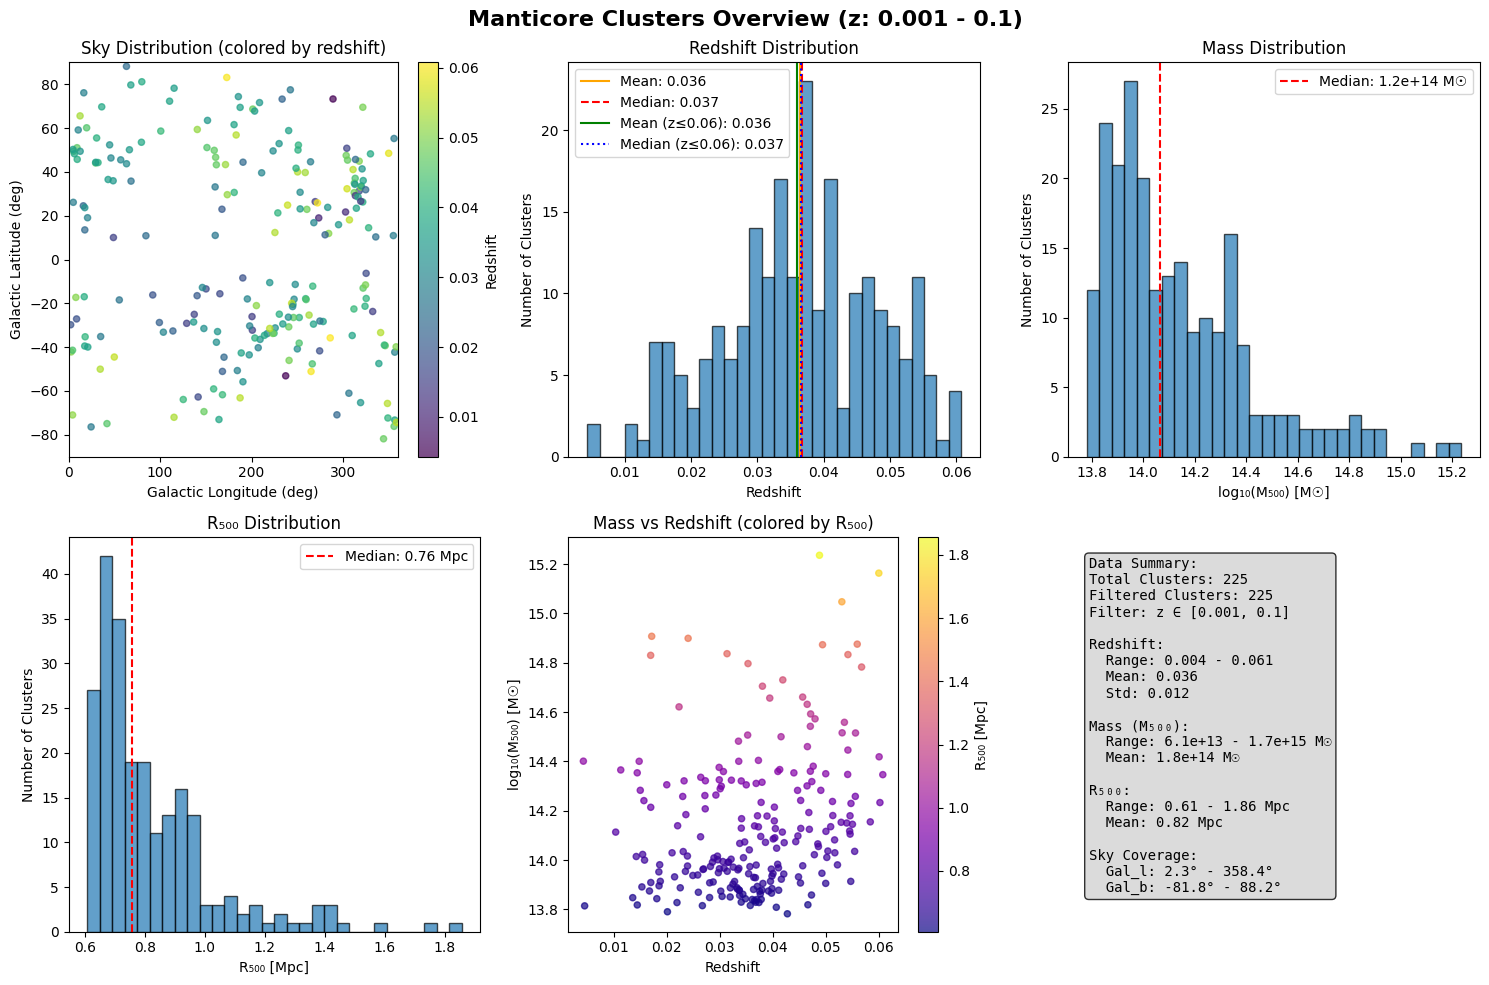

In [10]:
# plot_mcxc_overview(mcxc_data)  # Plot all data
plot_halo_overview(manticore_data, z_min=0.001, z_max=0.1, cat_name="Manticore")

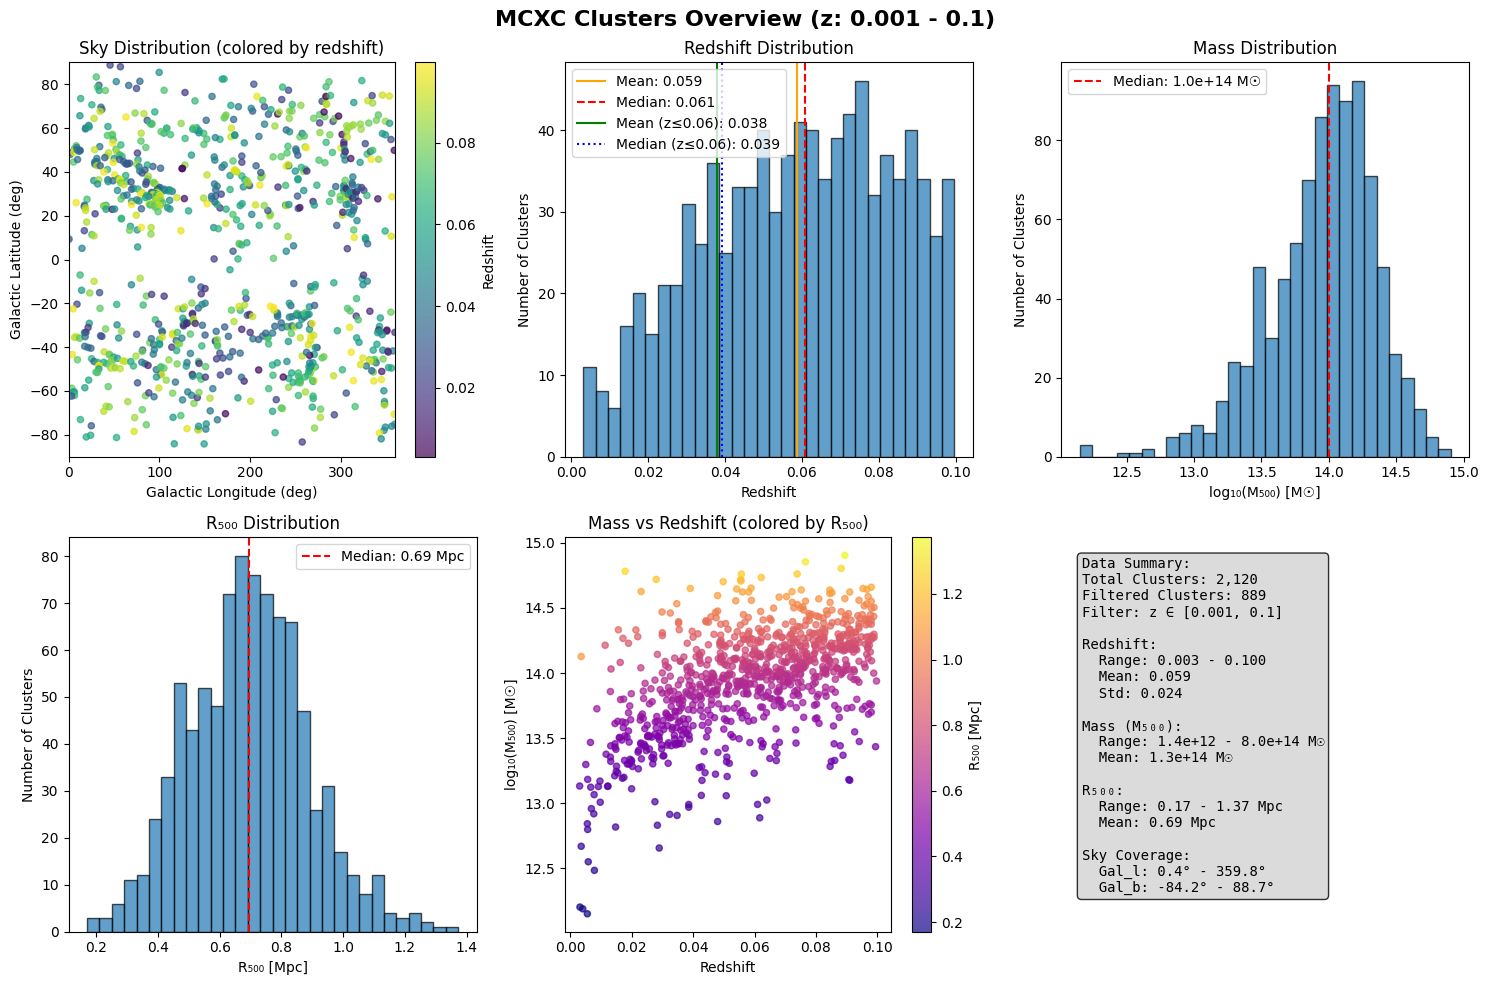

In [11]:
plot_halo_overview(mcxc_data, z_min=0.001, z_max=0.1, cat_name="MCXC")

/tmp/ipykernel_630557/76127243.py:76: RuntimeWarning: invalid value encountered in log10
  ax3.hist(np.log10(filtered_data["m500"]), bins=30, alpha=0.7, edgecolor='black')
/tmp/ipykernel_630557/76127243.py:96: RuntimeWarning: invalid value encountered in log10
  scatter2 = ax5.scatter(filtered_data["z"], np.log10(filtered_data["m500"]),


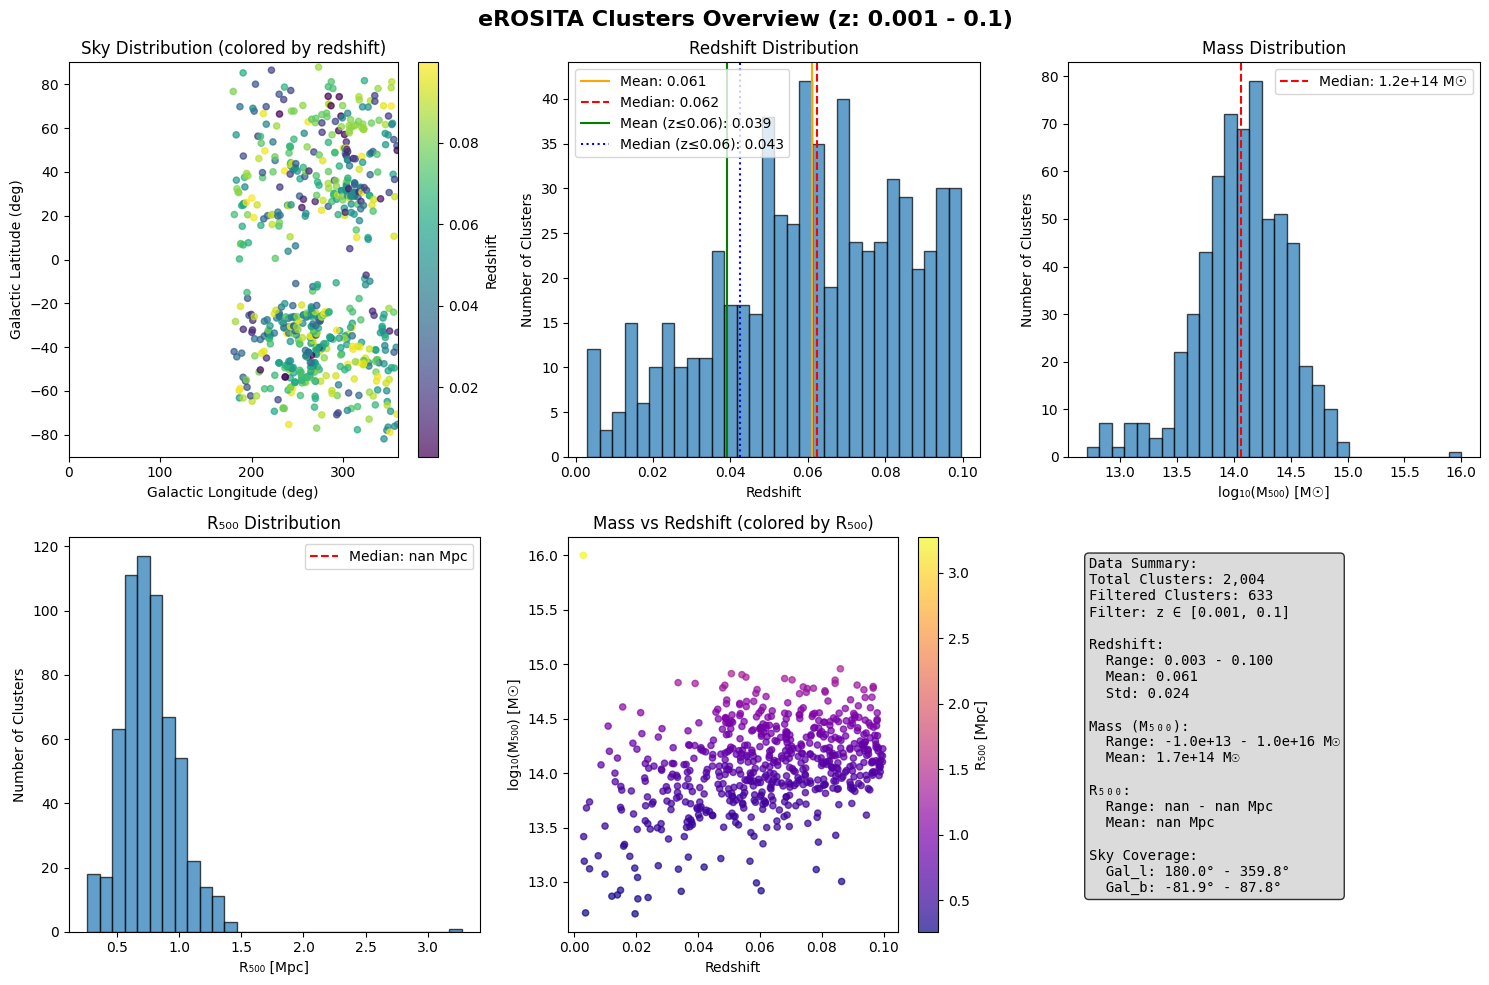

In [12]:
plot_halo_overview(eros_data, z_min=0.001, z_max=0.1, cat_name="eROSITA")

In [13]:
l_min = 20
l_max = 80

In [17]:
# bootstrap_methodology_validation_test_fixed.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, BoundaryNorm, ListedColormap
from stacking_backend.utils import mpc_to_angular_degrees
# assume `pipeline` and your data dicts (manticore_data, eros_data, mcxc_data) are already in scope

# ─── CONFIGURATION ────────────────────────────────────────────────────

mass_bins = [
    (1e14, 2e14),
    (2e14, 3e14),
    (3e14, 4e14),
]
selected_mass_bin_index = 1

# Create null dataset with random pointings but real manticore masses/r500s
np.random.seed(42)  # for reproducibility

# Use actual manticore masses, r500s, and redshifts
null_m500 = np.array(manticore_data['m500'])
null_r500 = np.array(manticore_data['r500'])
null_z = np.array(manticore_data['z'])
n_null = len(null_m500)

# Generate random gal_l (0-360 degrees)
null_gal_l = np.random.uniform(0, 360, n_null)

# Generate random gal_b within abs(10-80) constraint
null_gal_b = np.concatenate([
    np.random.uniform(-80, -10, n_null//2),
    np.random.uniform(10, 80, n_null - n_null//2)
])

null_data = {
    'gal_l': null_gal_l,
    'gal_b': null_gal_b,
    'z': null_z,
    'm500': null_m500,
    'r500': null_r500
}

datasets = {
    'manticore': manticore_data,
    'erosita':  eros_data,
    'mcxc':     mcxc_data,
    'null':     null_data
}

inner_r500_factor = 1.2
outer_r500_factor = 6.0
patch_size_deg    = 20.0
npix              = 512
z_min, z_max      = 0.005, 0.05
b_min, b_max      = 10, 80
n_radial_bins     = 50
min_coverage      = 0.8

# ─── RUN ANALYSIS ─────────────────────────────────────────────────────

results_dict = {}
for ds_name, ds_data in datasets.items():
    results_dict[ds_name] = {}
    for m1, m2 in mass_bins:
        label = f"{m1:.1e}-{m2:.1e}"
        coords = []
        for l, b, z, m500, r500 in zip(
                ds_data['gal_l'], ds_data['gal_b'],
                ds_data['z'],    ds_data['m500'], ds_data['r500']
            ):
            if (
                z_min < z < z_max and
                b_min < abs(b) < b_max and
                m1 <= m500 <= m2
            ):
                coords.append([l, b,
                               mpc_to_angular_degrees(r500, z),
                               z])
        coords = np.array(coords)
        if coords.size == 0:
            continue

        res = pipeline.run_individual_r500_analysis_with_validation(
            coord_list=coords,
            inner_r500_factor=inner_r500_factor,
            outer_r500_factor=outer_r500_factor,
            patch_size_deg=patch_size_deg,
            npix=npix,
            min_coverage=min_coverage,
            n_radial_bins=n_radial_bins,
            run_null_tests=False,
            n_bootstrap=100,
            n_random=0
        )
        results_dict[ds_name][label] = res


🚀 CLUSTER ANALYSIS PIPELINE (r500 Scaling + Validation)

🔍 Step 1: Individual cluster measurements...
🔍 Calculating individual cluster measurements with individual R500...
   ✅ Calculated 36 valid measurements
   ❌ Rejected: 18 clusters
      - insufficient_mask_coverage: 18

🔄 Step 2: Bootstrap error estimation (100 samples)...

📚 Step 3: Stacking patches...
🔄 Stacking 36 patches...
✅ Using 27 valid patches
   Rejected: 9 (coverage), 0 (errors)
   Stack dimensions: (512, 512)
   Valid pixel range: 17-27 patches

📊 Step 5: Radial profile in r/r500 units...
📊 Calculating radial profile in r/r500 units...
   Radial bins: 50, Max radius: 5.0 × r500
   Using median r500 = 0.295° for scaling
   Profile calculated: 50/50 valid bins
   Radial range: 0 to 5.0 × r500

🎯 Final Results:
✅ Bootstrap statistics:
   Mean Δy: 6.70e-07
   Bootstrap error: 1.38e-07
   Detection significance: 4.9σ
   68% CI: [5.30e-07, 8.17e-07]

📏 Sample statistics:
   R500 median: 0.295°
   Sample: 36/54 clusters

🎉 A

/tmp/ipykernel_630557/4157072451.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.1)


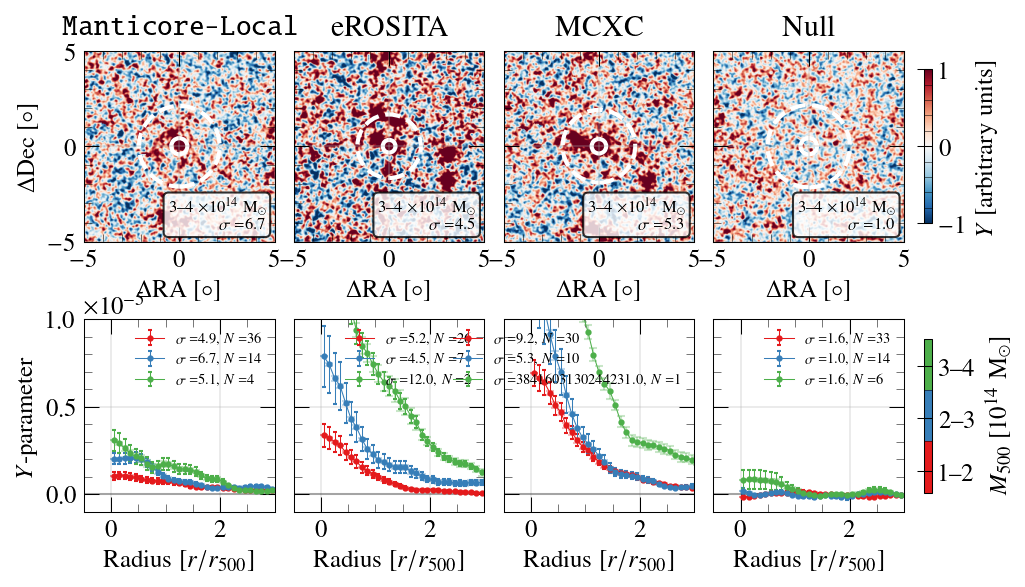

In [18]:

# pick mass‐label for top row
m1, m2 = mass_bins[selected_mass_bin_index]
selected_label = f"{m1:.1e}-{m2:.1e}"

# ─── GLOBAL vmin/vmax FOR PATCHES ─────────────────────────────────────
vmin, vmax = -1, 1

# ─── MASS→COLOR MAPPING ────────────────────────────────────────────────
mass_centers = np.sqrt(np.array([x*y for x,y in mass_bins]))
discrete_colors = ['#e41a1c', '#377eb8', '#4daf4a']
cmap_discrete = ListedColormap(discrete_colors)
mass_boundaries = [mass_bins[0][0]]
for m1, m2 in mass_bins:
    mass_boundaries.append(m2)
mass_boundaries = np.array(mass_boundaries)
norm_discrete = BoundaryNorm(mass_boundaries, ncolors=len(mass_bins))
colors = discrete_colors

# ─── FIGURE SETUP ──────────────────────────────────────────────────────
with plt.style.context(get_mplstyle_path(mnras_style)):
    fig, axes = plt.subplots(
        2, 4, figsize=(8.5, 4),
        gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.4, 'wspace': 0.1}
    )
    dataset_names = ['manticore', 'erosita', 'mcxc', 'null']
    dataset_labels = [r'$\texttt{Manticore-Local}$', 'eROSITA', 'MCXC', 'Null']
    top_images = []
    
    # ── Top row: Stacked patches with text annotations ─────────────────────
    for col, (ds, ds_label) in enumerate(zip(dataset_names, dataset_labels)):
        ax = axes[0, col]
        res = results_dict[ds].get(selected_label, {})
        patch = res.get('stacked_patch')
        if patch is not None:
            extent = [-patch_size_deg/2, patch_size_deg/2,
                      -patch_size_deg/2, patch_size_deg/2]
            im = ax.imshow(patch / 1e-6, origin='lower', extent=extent,
                           cmap='RdBu_r', vmin=vmin, vmax=vmax)
            top_images.append(im)
    
            # center marker & apertures
            #ax.plot(0, 0, 'k+', markersize=10)
            circ_in = plt.Circle((0, 0),
                                 res['r500_median'] * inner_r500_factor,
                                 fill=False, color='white', linewidth=2)
            circ_out = plt.Circle((0, 0),
                                  res['r500_median'] * outer_r500_factor,
                                  fill=False, color='white', linewidth=2, linestyle='--')
            ax.add_patch(circ_in)
            ax.add_patch(circ_out)
    
            # annotate mass range & sigma
            sigma = res.get('significance', np.nan)
            txt = f"{m1/1e14:.0f}–{m2/1e14:.0f} " + r"$\times 10^{14}$ M$_{\odot}$" + "\n" + r"$\sigma=$" + f"{sigma:.1f}"
            ax.text(0.95, 0.05, txt,
                    transform=ax.transAxes,
                    ha='right', va='bottom',
                    fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
            #ax.set_xlim(-patch_size_deg/2, patch_size_deg/2)
            #ax.set_ylim(-patch_size_deg/2, patch_size_deg/2)
            ax.set_xlim(-5,5)
            ax.set_ylim(-5,5)
            if col == 0:
                ax.set_ylabel(r'$\Delta$Dec [$\circ$]')
            ax.set_xlabel(r'$\Delta$RA [$\circ$]')
            ax.set_title(ds_label, pad=8)
            ax.grid(alpha=0.3)
            ax.set_aspect('equal')
        
            # turn off y-tick labels on columns 2, 3, and 4 of the top row
            if col > 0:
                ax.tick_params(labelleft=False)
        
    # shared vertical colorbar for top row
    if top_images:
        cbar_top = fig.colorbar(
            top_images[0], ax=axes[0, :],
            orientation='vertical', shrink=0.8, pad=0.02
        )
        cbar_top.set_label('$Y$ [arbitrary units]')
    
    # ── Bottom row: Radial profiles with dual error bars & mass colorbar ────
    for col, ds in enumerate(dataset_names):
        ax = axes[1, col]
        for idx, (m1, m2) in enumerate(mass_bins):
            label_key = f"{m1:.1e}-{m2:.1e}"
            res = results_dict[ds].get(label_key, {})
            r = res.get('profile_radii')
            y = res.get('profile_mean')
            e_pixel = res.get('profile_errors')  # pixel-level errors
            nsrc = res.get('n_measurements', 0)
            if r is None or y is None:
                continue
    
            mask = np.isfinite(r) & np.isfinite(y)
            if e_pixel is not None:
                mask &= np.isfinite(e_pixel)
            if not mask.any():
                continue
    
            # Calculate bootstrap error for each radial bin
            bootstrap_results = res.get('bootstrap_results', {})
            bootstrap_error = bootstrap_results.get('bootstrap_error', 0)
            
            # Scale bootstrap error to each radial bin (proportional to signal)
            if bootstrap_error > 0 and np.any(y[mask] != 0):
                # Bootstrap error scaled by the ratio of bin signal to total signal
                total_signal = res.get('mean_delta_y', 1)
                if total_signal != 0:
                    e_bootstrap = np.abs(y[mask]) * (bootstrap_error / abs(total_signal))
                else:
                    e_bootstrap = np.full_like(y[mask], bootstrap_error)
            else:
                e_bootstrap = np.full_like(y[mask], bootstrap_error)
    
            sigma = res.get('significance', np.nan)
            
            # Plot inner error bars (pixel-level) - smaller, faded
            ax.errorbar(
                r[mask], y[mask],
                yerr=e_pixel[mask] if e_pixel is not None else None,
                fmt='none', color=colors[idx], alpha=0.3,
                capsize=2, linewidth=1.5, elinewidth=1
            )
            
            # Plot outer error bars (bootstrap) - main opaque with markers
            ax.errorbar(
                r[mask], y[mask],
                yerr=e_bootstrap,
                fmt='o-', color=colors[idx],
                capsize=1, markersize=2, linewidth=0.5,
                label=r"$\sigma=$" + f"{sigma:.1f}, " + f"$N=$" + f"{nsrc}"
            )
    
        ax.axhline(0, color='black', linewidth=1, alpha=0.3)
        ax.grid(alpha=0.3)
        ax.set_xlim(-0.5, 3)
        ax.set_ylim(-0.1e-5, 1e-5)
        if col == 0:
            ax.set_ylabel('$Y$-parameter')
        else:
            ax.tick_params(labelleft=False)
        ax.set_xlabel(r"Radius [$r/r_{500}$]")
        ax.legend(loc='upper right', fontsize=7, frameon=False)
    
    # shared vertical colorbar for bottom row (mass → color)
    sm = ScalarMappable(cmap=cmap_discrete, norm=norm_discrete)
    sm.set_array([])
    cbar_bot = fig.colorbar(
        sm, ax=axes[1, :],
        orientation='vertical', shrink=0.8, pad=0.02,
        boundaries=mass_boundaries,
        ticks=mass_centers
    )
    cbar_bot.set_label(r'$M_{500}$ [$10^{14}$ M$_{\odot}$]')
    cbar_bot.set_ticklabels([f"{x/1e14:.0f}–{y/1e14:.0f}" for x, y in mass_bins])
    
    # ─── FINAL LAYOUT ───────────────────────────────────────────────────────
    plt.tight_layout(pad=0.1)
    plt.savefig("./plots/stacked_patches.pdf")
    plt.show()